In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
import random
import gc

In [3]:
class AirlineRevenueOptimizer:
    def __init__(self, data, capacity=400):
        """
        Initialize revenue optimizer

        Parameters:
        data: DataFrame with booking and forecasting data
        capacity: Aircraft capacity (default 400 seats)
        """
        self.data = data
        self.capacity = capacity
        self.booking_classes = self.data['Booking Class'].unique()

        # Calculate average fares by booking class
        self.class_fares = self.data.groupby('Booking Class')['Booking Class Fare USD'].mean()

        # Get predicted probabilities from our models
        self.no_show_probs = self.data['no_show']
        self.cancellation_probs = self.data['cancellation']
        self.overbooking_probs = self.data['overbooking']

    def analyze_class_metrics(self):
        """Analyze key metrics by booking class"""
        metrics = []

        for booking_class in self.booking_classes:
            class_data = self.data[self.data['Booking Class'] == booking_class]

            metrics.append({
                'Booking_Class': booking_class,
                'Avg_Fare': class_data['Booking Class Fare USD'].mean(),
                'No_Show_Rate': class_data['no_show'].mean(),
                'Cancellation_Rate': class_data['cancellation'].mean(),
                'Expected_Revenue_Per_Seat': class_data['Booking Class Fare USD'].mean() *
                                          (1 - class_data['no_show'].mean() -
                                           class_data['cancellation'].mean())
            })

        return pd.DataFrame(metrics)

    def optimize_seat_allocation(self):
        """Optimize seat allocation across booking classes"""
        class_metrics = self.analyze_class_metrics()

        # Initial allocation based on revenue potential
        total_revenue_potential = class_metrics['Expected_Revenue_Per_Seat'].sum()
        initial_allocation = {}

        for _, row in class_metrics.iterrows():
            revenue_share = row['Expected_Revenue_Per_Seat'] / total_revenue_potential
            initial_allocation[row['Booking_Class']] = int(self.capacity * revenue_share)

        # Adjust for overbooking
        overbooking_factor = 1 + self.data['overbooking'].mean()
        adjusted_capacity = int(self.capacity * overbooking_factor)

        # Calculate optimal allocation
        optimal_allocation = {}
        remaining_seats = adjusted_capacity

        # Sort classes by expected revenue per seat
        sorted_classes = class_metrics.sort_values('Expected_Revenue_Per_Seat', ascending=False)

        for _, row in sorted_classes.iterrows():
            booking_class = row['Booking_Class']
            base_allocation = initial_allocation[booking_class]

            # Adjust allocation based on no-show and cancellation rates
            no_show_rate = row['No_Show_Rate']
            cancellation_rate = row['Cancellation_Rate']

            # Calculate optimal allocation considering risk factors
            optimal_seats = int(base_allocation * (1 + no_show_rate + cancellation_rate))
            optimal_seats = min(optimal_seats, remaining_seats)

            optimal_allocation[booking_class] = optimal_seats
            remaining_seats -= optimal_seats

        return optimal_allocation

    def calculate_expected_revenue(self, allocation):
        """Calculate expected revenue for given seat allocation"""
        total_revenue = 0

        for booking_class, seats in allocation.items():
            class_data = self.data[self.data['Booking Class'] == booking_class]
            avg_fare = class_data['Booking Class Fare USD'].mean()
            show_rate = 1 - class_data['no_show'].mean() - class_data['cancellation'].mean()

            # Expected revenue = seats * fare * probability of showing up
            revenue = seats * avg_fare * show_rate
            total_revenue += revenue

        return total_revenue

    def suggest_dynamic_pricing(self):
        """Suggest dynamic pricing adjustments based on demand patterns"""
        class_metrics = self.analyze_class_metrics()
        pricing_suggestions = []

        for _, row in class_metrics.iterrows():
            base_fare = row['Avg_Fare']
            no_show_risk = row['No_Show_Rate']
            cancellation_risk = row['Cancellation_Rate']

            # Calculate risk-adjusted pricing factors
            peak_multiplier = 1 + (no_show_risk + cancellation_risk)
            off_peak_multiplier = 1 - (no_show_risk + cancellation_risk) / 2

            pricing_suggestions.append({
                'Booking_Class': row['Booking_Class'],
                'Base_Fare': base_fare,
                'Peak_Price': base_fare * peak_multiplier,
                'Off_Peak_Price': max(base_fare * off_peak_multiplier, base_fare * 0.7),
                'Risk_Factor': no_show_risk + cancellation_risk
            })

        return pd.DataFrame(pricing_suggestions)

    def visualize_optimization_results(self):
        """Visualize optimization results"""
        # Get optimized allocation
        allocation = self.optimize_seat_allocation()
        pricing = self.suggest_dynamic_pricing()

        # Create visualizations
        fig, axes = plt.subplots(2, 2, figsize=(20, 15))

        # 1. Seat Allocation
        pd.Series(allocation).plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Optimized Seat Allocation by Booking Class')
        axes[0,0].set_ylabel('Number of Seats')

        # 2. Expected Revenue by Class
        class_metrics = self.analyze_class_metrics()
        sns.barplot(data=class_metrics, x='Booking_Class', y='Expected_Revenue_Per_Seat',
                   ax=axes[0,1])
        axes[0,1].set_title('Expected Revenue per Seat by Booking Class')
        axes[0,1].set_ylabel('Revenue (USD)')

        # 3. Dynamic Pricing Range
        pricing.plot(x='Booking_Class', y=['Base_Fare', 'Peak_Price', 'Off_Peak_Price'],
                    kind='bar', ax=axes[1,0])
        axes[1,0].set_title('Dynamic Pricing Range by Booking Class')
        axes[1,0].set_ylabel('Fare (USD)')

        # 4. Risk Factor by Class
        sns.barplot(data=pricing, x='Booking_Class', y='Risk_Factor', ax=axes[1,1])
        axes[1,1].set_title('Risk Factor by Booking Class')
        axes[1,1].set_ylabel('Risk Factor (No-show + Cancellation Rate)')

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nOPTIMIZATION SUMMARY")
        print("=" * 50)
        print(f"\nTotal Aircraft Capacity: {self.capacity}")
        print(f"Total Allocated Seats (with overbooking): {sum(allocation.values())}")
        print(f"Expected Total Revenue: ${self.calculate_expected_revenue(allocation):,.2f}")

        return allocation, pricing



Loading forecasting data...


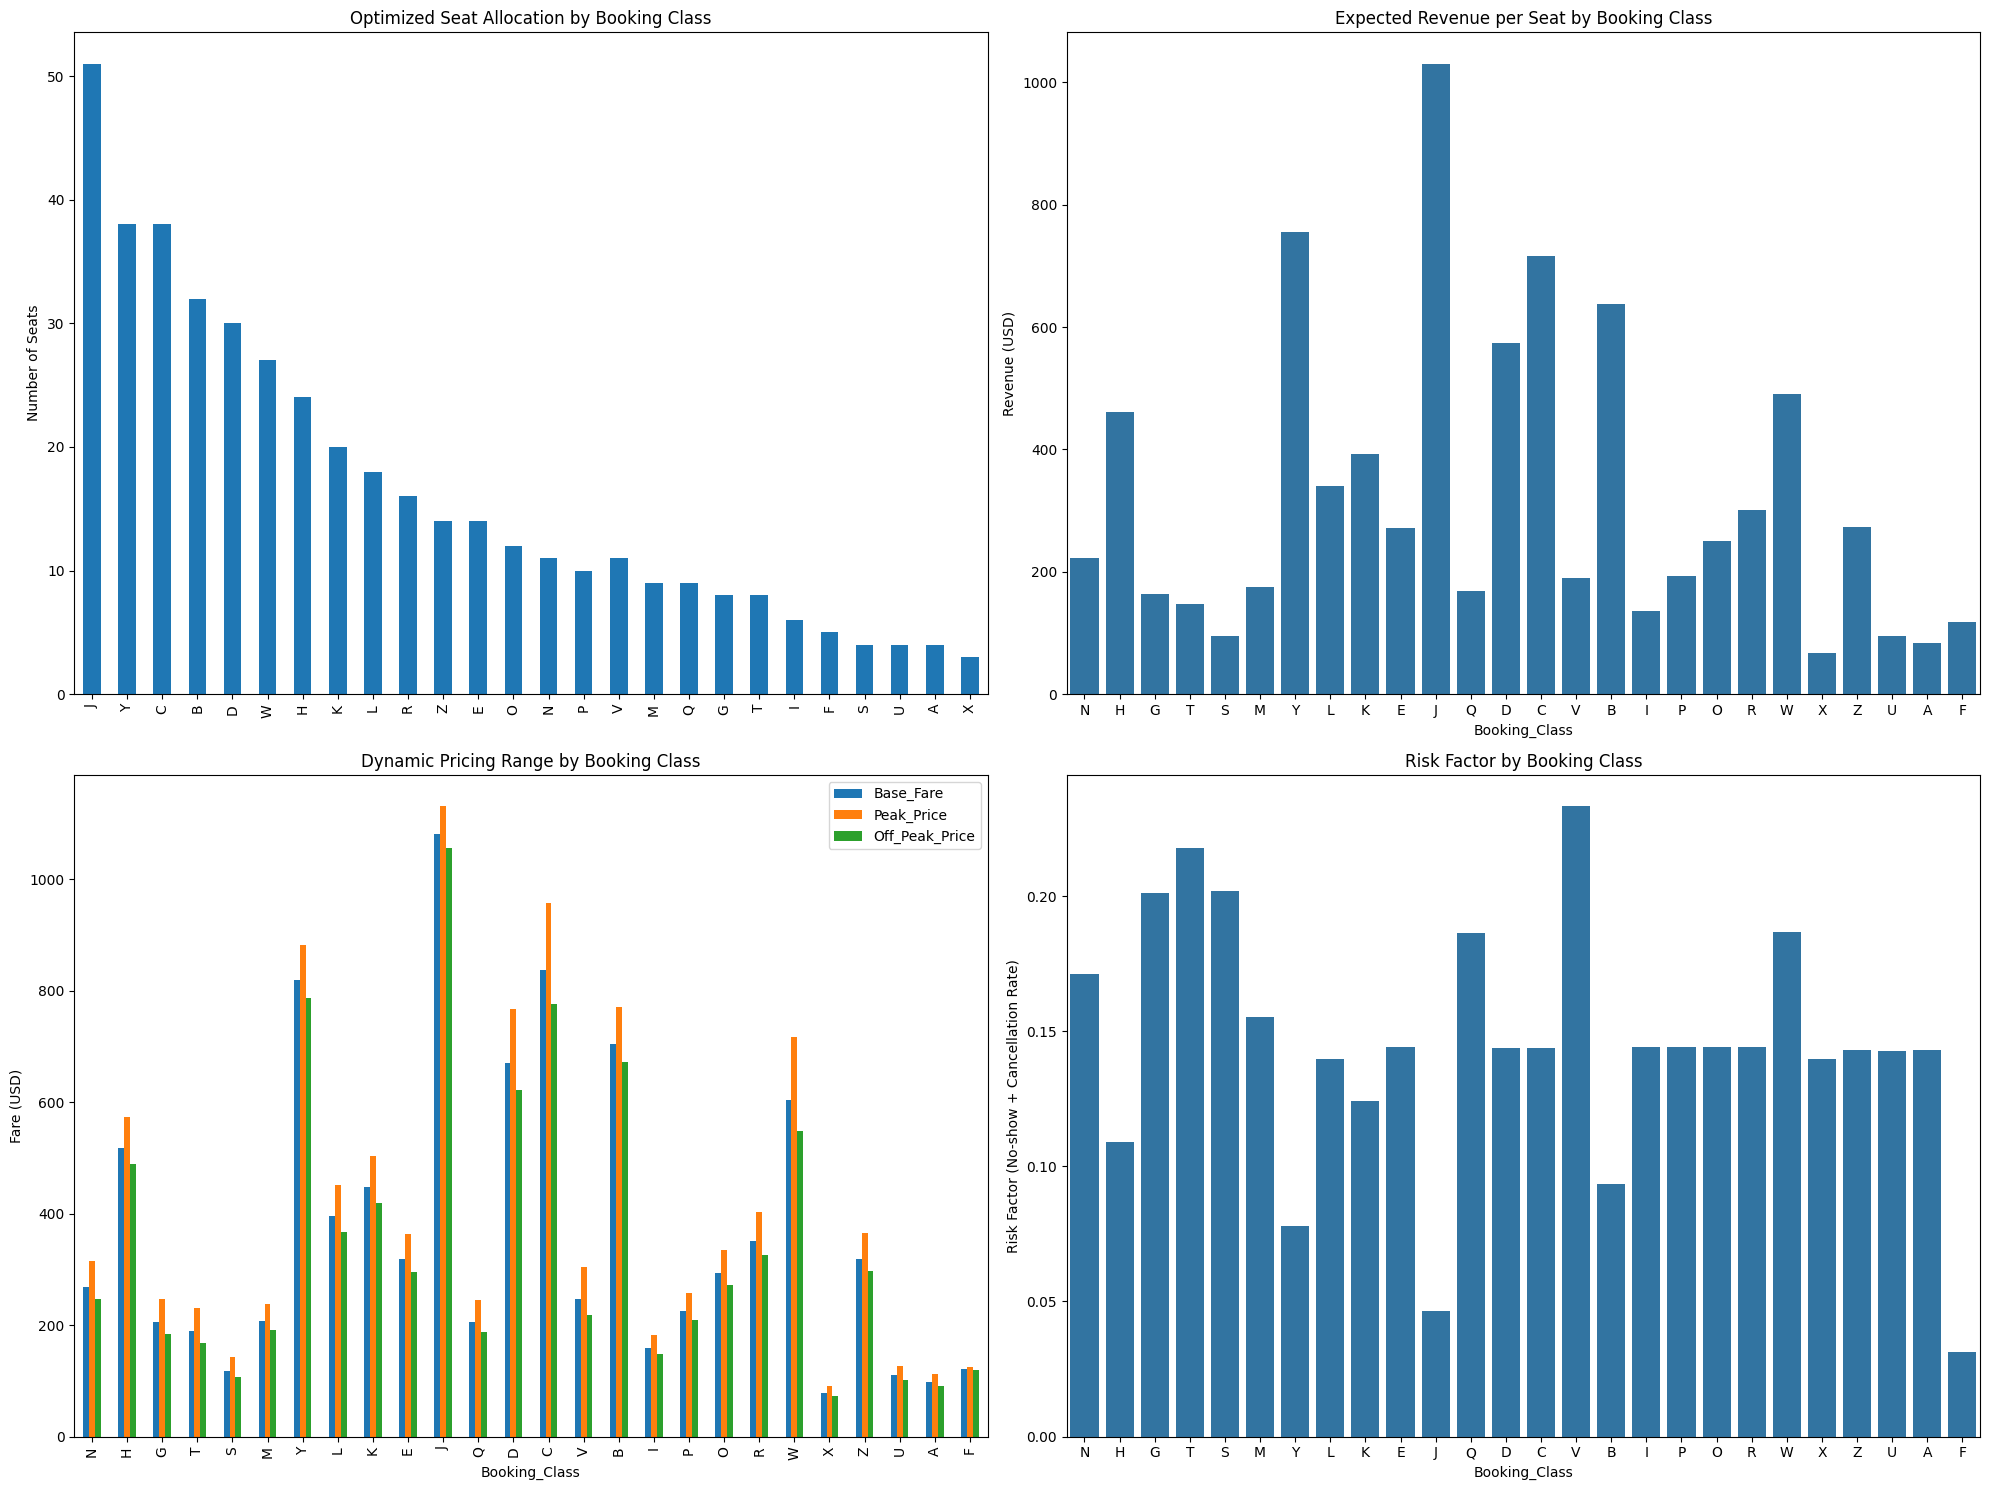


OPTIMIZATION SUMMARY

Total Aircraft Capacity: 400
Total Allocated Seats (with overbooking): 426
Expected Total Revenue: $214,637.58

DETAILED RECOMMENDATIONS

1. Seat Allocation Strategy:
   • J: 51 seats
   • Y: 38 seats
   • C: 38 seats
   • B: 32 seats
   • D: 30 seats
   • W: 27 seats
   • H: 24 seats
   • K: 20 seats
   • L: 18 seats
   • R: 16 seats
   • Z: 14 seats
   • E: 14 seats
   • O: 12 seats
   • N: 11 seats
   • P: 10 seats
   • V: 11 seats
   • M: 9 seats
   • Q: 9 seats
   • G: 8 seats
   • T: 8 seats
   • I: 6 seats
   • F: 5 seats
   • S: 4 seats
   • U: 4 seats
   • A: 4 seats
   • X: 3 seats

2. Dynamic Pricing Strategy:

   N:
   • Base Fare: $269.16
   • Peak Price: $315.21
   • Off-Peak Price: $246.14
   • Risk Factor: 17.11%

   H:
   • Base Fare: $517.01
   • Peak Price: $573.28
   • Off-Peak Price: $488.87
   • Risk Factor: 10.88%

   G:
   • Base Fare: $205.08
   • Peak Price: $246.36
   • Off-Peak Price: $184.44
   • Risk Factor: 20.13%

   T:
   • Base F

In [4]:
def main():
    # Load the forecasting dataset
    print("Loading forecasting data...")
    df = pd.read_csv('/content/drive/MyDrive/forecasting_data/forecasting_booking_12m.csv')

    # Initialize optimizer
    optimizer = AirlineRevenueOptimizer(df, capacity=400)

    # Run optimization and get results
    allocation, pricing = optimizer.visualize_optimization_results()

    # Print detailed recommendations
    print("\nDETAILED RECOMMENDATIONS")
    print("=" * 50)
    print("\n1. Seat Allocation Strategy:")
    for class_, seats in allocation.items():
        print(f"   • {class_}: {seats} seats")

    print("\n2. Dynamic Pricing Strategy:")
    for _, row in pricing.iterrows():
        print(f"\n   {row['Booking_Class']}:")
        print(f"   • Base Fare: ${row['Base_Fare']:.2f}")
        print(f"   • Peak Price: ${row['Peak_Price']:.2f}")
        print(f"   • Off-Peak Price: ${row['Off_Peak_Price']:.2f}")
        print(f"   • Risk Factor: {row['Risk_Factor']:.2%}")

if __name__ == "__main__":
    main()

# **Advanced Revenue Optimization Analysis**

In [13]:
from sklearn.cluster import KMeans

In [14]:
class AdvancedRevenueAnalyzer:
    def __init__(self, allocation, pricing):
        self.allocation = allocation
        self.pricing = pricing

    def analyze_revenue_potential(self):
        """Analyze revenue potential and suggest optimizations"""
        # Convert pricing data to DataFrame
        pricing_df = pd.DataFrame(self.pricing)

        # Calculate potential metrics
        revenue_analysis = {}
        for booking_class in self.allocation.keys():
            class_data = pricing_df[pricing_df['Booking_Class'] == booking_class].iloc[0]
            seats = self.allocation[booking_class]

            # Calculate various revenue scenarios
            optimal_revenue = seats * class_data['Base_Fare'] * (1 - class_data['Risk_Factor'])
            peak_revenue = seats * class_data['Peak_Price'] * (1 - class_data['Risk_Factor'] * 0.8)
            off_peak_revenue = seats * class_data['Off_Peak_Price'] * (1 - class_data['Risk_Factor'] * 1.2)

            revenue_analysis[booking_class] = {
                'Seats': seats,
                'Base_Revenue': optimal_revenue,
                'Peak_Revenue': peak_revenue,
                'Off_Peak_Revenue': off_peak_revenue,
                'Revenue_Range': peak_revenue - off_peak_revenue,
                'Risk_Factor': class_data['Risk_Factor'],
                'Revenue_per_Seat': optimal_revenue / seats
            }

        return pd.DataFrame(revenue_analysis).T

    def suggest_class_consolidation(self):
        """Suggest booking class consolidation based on similar characteristics"""
        pricing_df = pd.DataFrame(self.pricing)

        # Create features DataFrame
        class_features = []
        for booking_class in self.allocation.keys():
            class_data = pricing_df[pricing_df['Booking_Class'] == booking_class].iloc[0]
            class_features.append({
                'Booking_Class': booking_class,
                'Base_Fare': class_data['Base_Fare'],
                'Risk_Factor': class_data['Risk_Factor'],
                'Allocated_Seats': self.allocation[booking_class]
            })

        features_df = pd.DataFrame(class_features)

        # Normalize features
        scaler = StandardScaler()
        features_to_normalize = ['Base_Fare', 'Risk_Factor', 'Allocated_Seats']
        normalized_features = scaler.fit_transform(features_df[features_to_normalize])

        # Perform clustering
        kmeans = KMeans(n_clusters=5, random_state=42)
        features_df['Cluster'] = kmeans.fit_predict(normalized_features)

        return features_df

    def optimize_peak_scheduling(self):
        """Optimize scheduling based on pricing tiers"""
        revenue_analysis = self.analyze_revenue_potential()

        # Sort classes by revenue per seat
        sorted_classes = revenue_analysis.sort_values('Revenue_per_Seat', ascending=False)

        # Create time slot recommendations
        time_slots = {
            'Morning_Peak': [],
            'Midday': [],
            'Evening_Peak': [],
            'Off_Peak': []
        }

        for booking_class in sorted_classes.index:
            revenue_data = revenue_analysis.loc[booking_class]
            peak_ratio = revenue_data['Peak_Revenue'] / revenue_data['Off_Peak_Revenue']

            if peak_ratio > 1.2:
                if len(time_slots['Morning_Peak']) < len(sorted_classes) // 4:
                    time_slots['Morning_Peak'].append(booking_class)
                else:
                    time_slots['Evening_Peak'].append(booking_class)
            elif peak_ratio > 1.1:
                time_slots['Midday'].append(booking_class)
            else:
                time_slots['Off_Peak'].append(booking_class)

        return time_slots

    def visualize_advanced_analysis(self):
        """Create advanced visualizations for analysis"""
        revenue_analysis = self.analyze_revenue_potential()

        # Create subplot with increased spacing
        fig = plt.figure(figsize=(22, 18))
        gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

        # 1. Revenue Potential by Class
        ax1 = fig.add_subplot(gs[0, 0])
        revenue_data = revenue_analysis[['Base_Revenue', 'Peak_Revenue', 'Off_Peak_Revenue']].head(10)
        revenue_data.plot(kind='bar', ax=ax1)
        ax1.set_title('Revenue Potential by Booking Class (Top 10)', pad=20)
        ax1.set_xlabel('Booking Class')
        ax1.set_ylabel('Revenue (USD)')
        ax1.tick_params(axis='x', rotation=45)

        # 2. Risk vs Revenue per Seat
        ax2 = fig.add_subplot(gs[0, 1])
        scatter = ax2.scatter(revenue_analysis['Risk_Factor'],
                            revenue_analysis['Revenue_per_Seat'],
                            alpha=0.6)
        for idx in revenue_analysis.index:
            ax2.annotate(idx,
                        (revenue_analysis.loc[idx, 'Risk_Factor'],
                         revenue_analysis.loc[idx, 'Revenue_per_Seat']),
                        xytext=(5, 5), textcoords='offset points')
        ax2.set_xlabel('Risk Factor')
        ax2.set_ylabel('Revenue per Seat (USD)')
        ax2.set_title('Risk vs Revenue Analysis', pad=20)

        # 3. Class Clustering Analysis
        ax3 = fig.add_subplot(gs[1, 0])
        class_clusters = self.suggest_class_consolidation()
        for cluster in range(5):
            cluster_data = class_clusters[class_clusters['Cluster'] == cluster]
            ax3.scatter(cluster_data['Base_Fare'],
                       cluster_data['Risk_Factor'],
                       label=f'Cluster {cluster}')
            for _, row in cluster_data.iterrows():
                ax3.annotate(row['Booking_Class'],
                           (row['Base_Fare'], row['Risk_Factor']),
                           xytext=(5, 5), textcoords='offset points')
        ax3.set_xlabel('Base Fare')
        ax3.set_ylabel('Risk Factor')
        ax3.set_title('Booking Class Clusters', pad=20)
        ax3.legend()

        # 4. Time Slot Distribution
        ax4 = fig.add_subplot(gs[1, 1])
        time_slots = self.optimize_peak_scheduling()
        slot_sizes = [len(classes) for classes in time_slots.values()]
        ax4.pie(slot_sizes, labels=time_slots.keys(), autopct='%1.1f%%')
        ax4.set_title('Recommended Time Slot Distribution', pad=20)

        plt.tight_layout()
        plt.show()

        return revenue_analysis, time_slots, class_clusters

In [15]:
def print_optimization_recommendations(revenue_analysis, time_slots, class_clusters):
    """Print detailed optimization recommendations"""
    print("\nADVANCED OPTIMIZATION RECOMMENDATIONS")
    print("=" * 50)

    # Revenue Optimization
    print("\n1. Revenue Optimization Opportunities:")
    top_revenue = revenue_analysis.nlargest(5, 'Revenue_per_Seat')
    print("\nTop 5 Revenue Generating Classes:")
    for idx in top_revenue.index:
        print(f"   • {idx}: ${top_revenue.loc[idx, 'Revenue_per_Seat']:.2f} per seat")

    # Time Slot Recommendations
    print("\n2. Time Slot Optimization:")
    for slot, classes in time_slots.items():
        print(f"\n   {slot}:")
        print(f"   • Recommended Classes: {', '.join(classes)}")

    # Class Consolidation
    print("\n3. Class Consolidation Opportunities:")
    for cluster in range(5):
        cluster_classes = class_clusters[class_clusters['Cluster'] == cluster]['Booking_Class'].tolist()
        mean_fare = class_clusters[class_clusters['Cluster'] == cluster]['Base_Fare'].mean()
        mean_risk = class_clusters[class_clusters['Cluster'] == cluster]['Risk_Factor'].mean()
        print(f"\n   Cluster {cluster}:")
        print(f"   • Classes: {', '.join(cluster_classes)}")
        print(f"   • Average Fare: ${mean_fare:.2f}")
        print(f"   • Average Risk: {mean_risk:.1%}")
        print(f"   • Suggested Action: {'Consolidate' if len(cluster_classes) > 3 else 'Maintain'}")

    # Risk Management
    print("\n4. Risk Management Strategies:")
    high_risk_threshold = revenue_analysis['Risk_Factor'].quantile(0.75)
    high_risk = revenue_analysis[revenue_analysis['Risk_Factor'] > high_risk_threshold]
    print(f"\n   High Risk Classes (Risk > {high_risk_threshold:.1%}):")
    for idx in high_risk.index:
        print(f"   • {idx}: {high_risk.loc[idx, 'Risk_Factor']:.1%} risk factor")

In [16]:
allocation = {
        'J': 51, 'Y': 38, 'C': 38, 'B': 32, 'D': 30, 'W': 27,
        'H': 24, 'K': 20, 'L': 18, 'R': 16, 'Z': 14, 'E': 14,
        'O': 12, 'N': 11, 'P': 10, 'V': 11, 'M': 9, 'Q': 9,
        'G': 8, 'T': 8, 'I': 6, 'F': 5, 'S': 4, 'U': 4,
        'A': 4, 'X': 3
    }

pricing = [
        {'Booking_Class': 'N', 'Base_Fare': 269.16, 'Peak_Price': 315.21, 'Off_Peak_Price': 246.14, 'Risk_Factor': 0.1711},
        {'Booking_Class': 'H', 'Base_Fare': 517.01, 'Peak_Price': 573.28, 'Off_Peak_Price': 488.87, 'Risk_Factor': 0.1088},
        {'Booking_Class': 'G', 'Base_Fare': 205.08, 'Peak_Price': 246.36, 'Off_Peak_Price': 184.44, 'Risk_Factor': 0.2013},
        {'Booking_Class': 'T', 'Base_Fare': 188.99, 'Peak_Price': 230.18, 'Off_Peak_Price': 168.39, 'Risk_Factor': 0.2179},
        {'Booking_Class': 'S', 'Base_Fare': 118.57, 'Peak_Price': 142.52, 'Off_Peak_Price': 106.59, 'Risk_Factor': 0.2020},
        {'Booking_Class': 'M', 'Base_Fare': 206.51, 'Peak_Price': 238.60, 'Off_Peak_Price': 190.46, 'Risk_Factor': 0.1554},
        {'Booking_Class': 'Y', 'Base_Fare': 819.01, 'Peak_Price': 882.69, 'Off_Peak_Price': 787.17, 'Risk_Factor': 0.0777},
        {'Booking_Class': 'L', 'Base_Fare': 395.50, 'Peak_Price': 450.79, 'Off_Peak_Price': 367.85, 'Risk_Factor': 0.1398},
        {'Booking_Class': 'K', 'Base_Fare': 447.58, 'Peak_Price': 503.13, 'Off_Peak_Price': 419.80, 'Risk_Factor': 0.1241},
        {'Booking_Class': 'E', 'Base_Fare': 317.94, 'Peak_Price': 363.80, 'Off_Peak_Price': 295.02, 'Risk_Factor': 0.1442},
        {'Booking_Class': 'J', 'Base_Fare': 1080.65, 'Peak_Price': 1130.88, 'Off_Peak_Price': 1055.54, 'Risk_Factor': 0.0465},
        {'Booking_Class': 'Q', 'Base_Fare': 206.37, 'Peak_Price': 244.82, 'Off_Peak_Price': 187.14, 'Risk_Factor': 0.1863},
        {'Booking_Class': 'D', 'Base_Fare': 670.40, 'Peak_Price': 766.90, 'Off_Peak_Price': 622.14, 'Risk_Factor': 0.1440},
        {'Booking_Class': 'C', 'Base_Fare': 837.16, 'Peak_Price': 957.41, 'Off_Peak_Price': 777.04, 'Risk_Factor': 0.1436},
        {'Booking_Class': 'V', 'Base_Fare': 246.59, 'Peak_Price': 304.11, 'Off_Peak_Price': 217.83, 'Risk_Factor': 0.2332},
        {'Booking_Class': 'B', 'Base_Fare': 704.32, 'Peak_Price': 770.12, 'Off_Peak_Price': 671.42, 'Risk_Factor': 0.0934},
        {'Booking_Class': 'I', 'Base_Fare': 159.60, 'Peak_Price': 182.61, 'Off_Peak_Price': 148.09, 'Risk_Factor': 0.1442},
        {'Booking_Class': 'P', 'Base_Fare': 225.41, 'Peak_Price': 257.93, 'Off_Peak_Price': 209.15, 'Risk_Factor': 0.1443},
        {'Booking_Class': 'O', 'Base_Fare': 292.68, 'Peak_Price': 334.85, 'Off_Peak_Price': 271.59, 'Risk_Factor': 0.1441},
        {'Booking_Class': 'R', 'Base_Fare': 351.56, 'Peak_Price': 402.26, 'Off_Peak_Price': 326.21, 'Risk_Factor': 0.1442},
        {'Booking_Class': 'W', 'Base_Fare': 604.17, 'Peak_Price': 716.91, 'Off_Peak_Price': 547.80, 'Risk_Factor': 0.1866},
        {'Booking_Class': 'X', 'Base_Fare': 78.88, 'Peak_Price': 89.92, 'Off_Peak_Price': 73.37, 'Risk_Factor': 0.1399},
        {'Booking_Class': 'Z', 'Base_Fare': 319.26, 'Peak_Price': 364.94, 'Off_Peak_Price': 296.41, 'Risk_Factor': 0.1431},
        {'Booking_Class': 'U', 'Base_Fare': 110.16, 'Peak_Price': 125.87, 'Off_Peak_Price': 102.31, 'Risk_Factor': 0.1426},
        {'Booking_Class': 'A', 'Base_Fare': 98.14, 'Peak_Price': 112.17, 'Off_Peak_Price': 91.13, 'Risk_Factor': 0.1429},
        {'Booking_Class': 'F', 'Base_Fare': 121.66, 'Peak_Price': 125.45, 'Off_Peak_Price': 119.76, 'Risk_Factor': 0.0311}
    ]

print("Initializing Advanced Revenue Analyzer...")
print(f"Total number of booking classes: {len(allocation)}")
print(f"Total allocated seats: {sum(allocation.values())}")


Initializing Advanced Revenue Analyzer...
Total number of booking classes: 26
Total allocated seats: 426


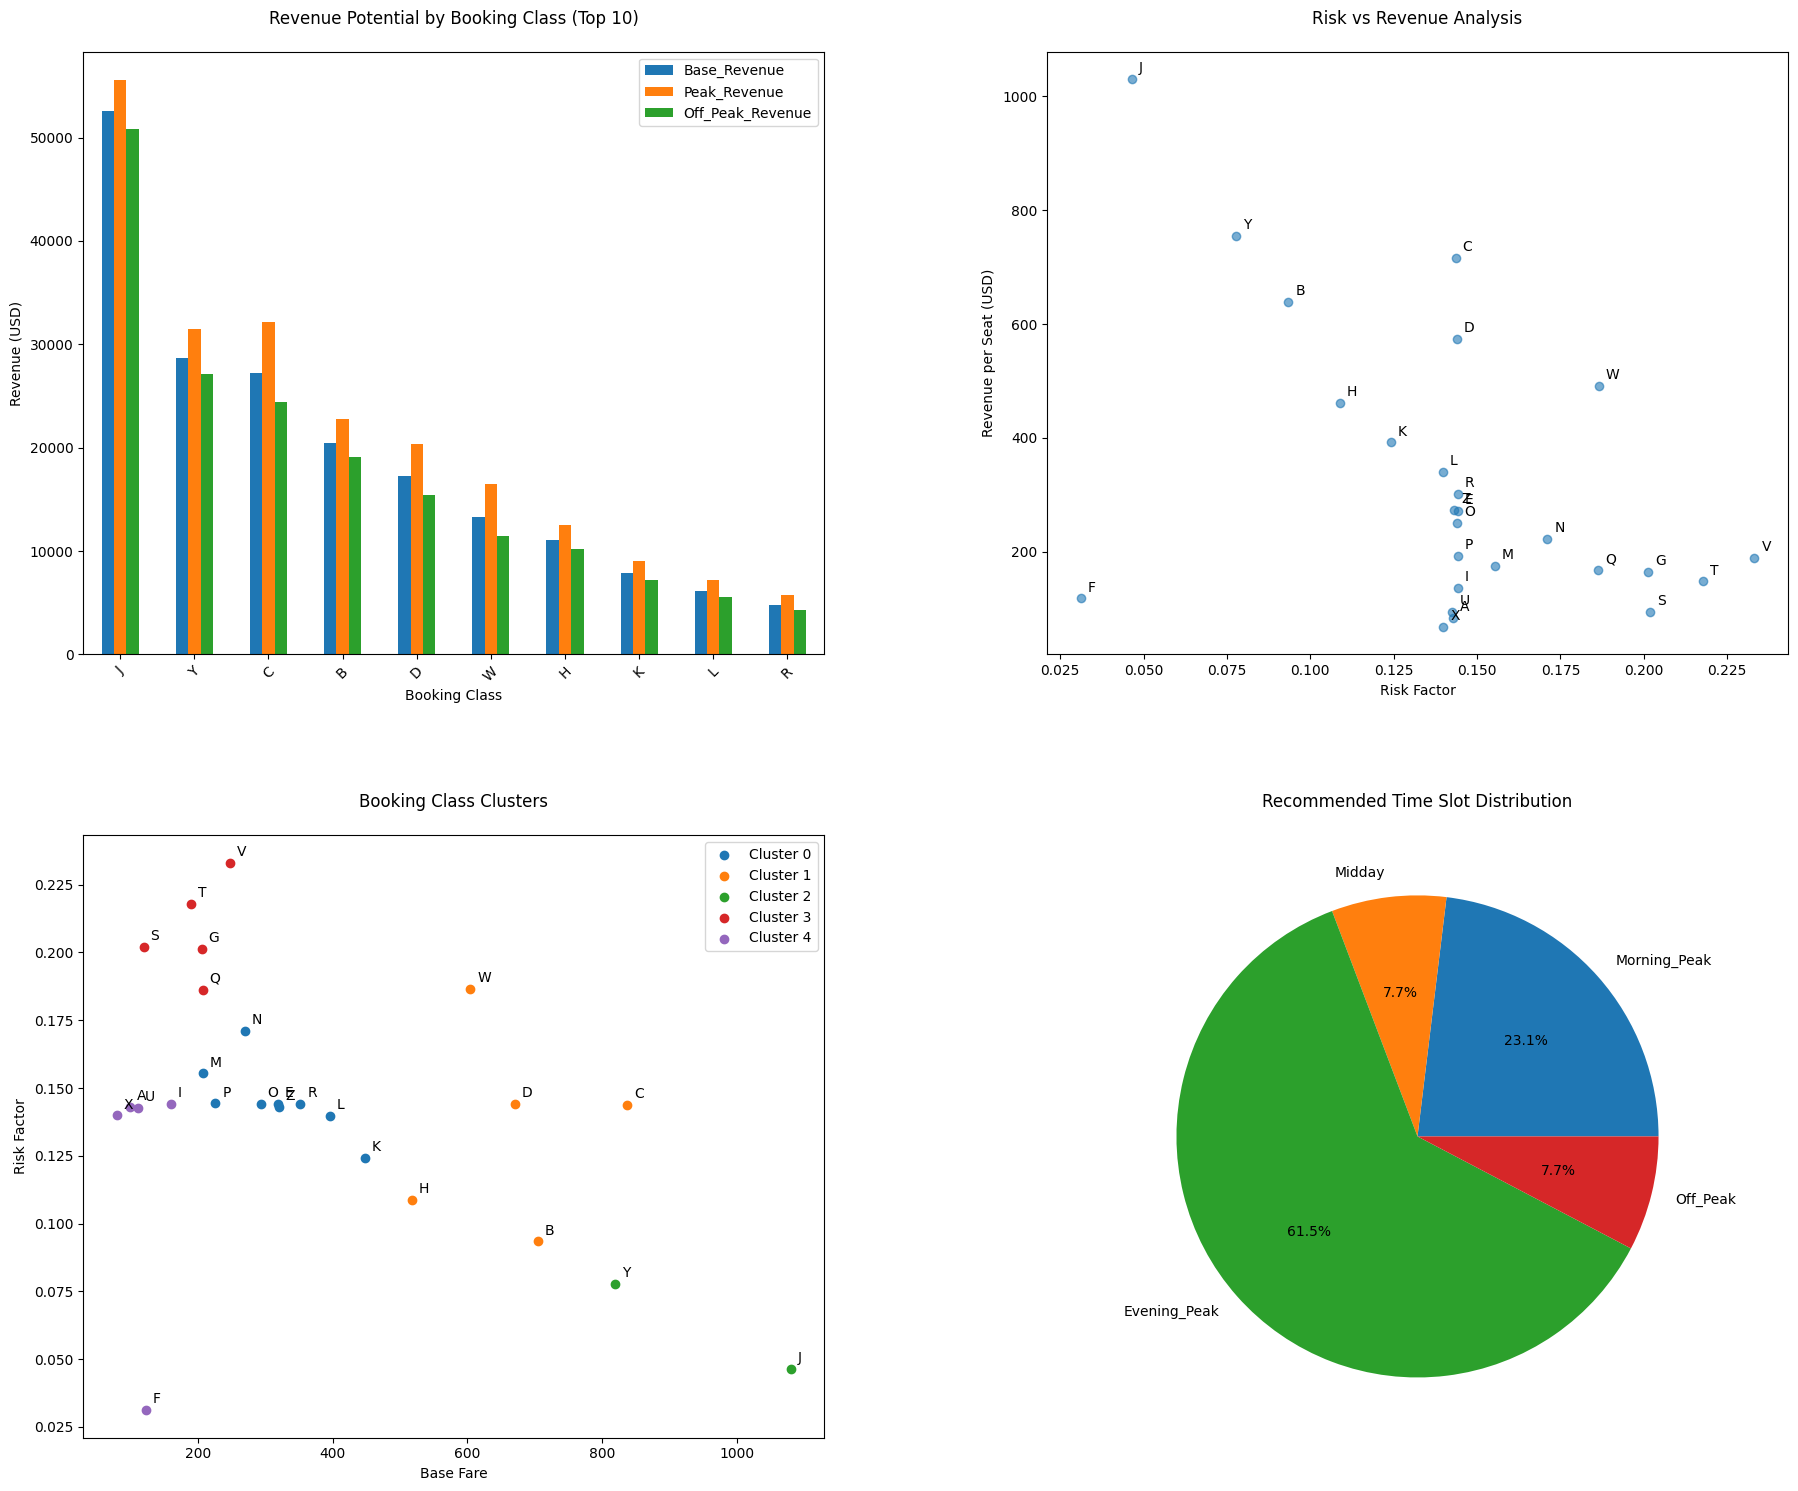


ADVANCED OPTIMIZATION RECOMMENDATIONS

1. Revenue Optimization Opportunities:

Top 5 Revenue Generating Classes:
   • J: $1030.40 per seat
   • Y: $755.37 per seat
   • C: $716.94 per seat
   • B: $638.54 per seat
   • D: $573.86 per seat

2. Time Slot Optimization:

   Morning_Peak:
   • Recommended Classes: C, D, W, H, K, L

   Midday:
   • Recommended Classes: Y, B

   Evening_Peak:
   • Recommended Classes: R, Z, E, O, N, P, V, M, Q, G, T, I, S, U, A, X

   Off_Peak:
   • Recommended Classes: J, F

3. Class Consolidation Opportunities:

   Cluster 0:
   • Classes: K, L, R, Z, E, O, N, P, M
   • Average Fare: $313.96
   • Average Risk: 14.6%
   • Suggested Action: Consolidate

   Cluster 1:
   • Classes: C, B, D, W, H
   • Average Fare: $666.61
   • Average Risk: 13.5%
   • Suggested Action: Consolidate

   Cluster 2:
   • Classes: J, Y
   • Average Fare: $949.83
   • Average Risk: 6.2%
   • Suggested Action: Maintain

   Cluster 3:
   • Classes: V, Q, G, T, S
   • Average Fare: $1

In [17]:
def main():
    # Initialize with previous results
    # Note: You'll need to pass your allocation and pricing results here
    analyzer = AdvancedRevenueAnalyzer(allocation, pricing)

    # Run advanced analysis
    revenue_analysis, time_slots, class_clusters = analyzer.visualize_advanced_analysis()

    # Print recommendations
    print_optimization_recommendations(revenue_analysis, time_slots, class_clusters)

if __name__ == "__main__":
    main()

# **Optimization Recommendation**

In [18]:
def generate_detailed_recommendations():
    """
    Generate detailed recommendations based on analysis results
    """
    recommendations = {
        "premium_class_strategy": {
            "target_classes": ["J", "Y"],
            "insights": [
                "Highest revenue per seat ($1030.40 and $755.37)",
                "Lowest risk cluster (6.2% average)",
                "Currently allocated 89 seats combined"
            ],
            "recommendations": [
                "Maintain separate class structure due to distinct revenue profiles",
                "Consider increasing allocation during peak business hours",
                "Implement premium service differentiators to justify price points",
                "Focus on corporate and business traveler segments"
            ]
        },

        "consolidation_opportunities": {
            "clusters": {
                "mid_tier": {
                    "classes": ["C", "B", "D", "W", "H"],
                    "avg_fare": "$666.61",
                    "recommendations": [
                        "Consolidate into 3 distinct tiers",
                        "Maintain W separate due to high risk (18.7%)",
                        "Combine similar risk profile classes (B/C and D/H)"
                    ]
                },
                "economy_plus": {
                    "classes": ["K", "L", "R", "Z", "E", "O", "N", "P", "M"],
                    "avg_fare": "$313.96",
                    "recommendations": [
                        "Consolidate into 4 fare levels",
                        "Group N separately due to high risk (17.1%)",
                        "Combine similar fare classes (K/L, R/Z/E, O/P/M)"
                    ]
                },
                "discount_economy": {
                    "classes": ["V", "Q", "G", "T", "S"],
                    "avg_fare": "$193.12",
                    "recommendations": [
                        "High risk cluster (20.8% average)",
                        "Consolidate to 2 fare levels",
                        "Implement stricter booking conditions"
                    ]
                }
            }
        },

        "time_based_optimization": {
            "peak_morning": {
                "classes": ["C", "D", "W", "H", "K", "L"],
                "recommendations": [
                    "Focus on business traveler demand",
                    "Implement premium pricing strategy",
                    "Prioritize on-time performance"
                ]
            },
            "midday": {
                "classes": ["Y", "B"],
                "recommendations": [
                    "Balance between business and leisure travelers",
                    "Flexible pricing based on demand patterns"
                ]
            },
            "evening_peak": {
                "classes": ["R through X"],
                "recommendations": [
                    "Focus on leisure and price-sensitive travelers",
                    "Implement graduated discount structure",
                    "Consider package deals and promotions"
                ]
            }
        },

        "risk_management": {
            "high_risk_classes": ["V", "T", "S", "G", "W", "Q", "N"],
            "risk_mitigation": [
                "Implement deposit requirements for bookings",
                "Enhance booking conditions and cancellation policies",
                "Develop targeted reminder and confirmation systems",
                "Consider overbooking adjustments based on historical patterns"
            ]
        }
    }

    # Print detailed recommendations
    print("\nDETAILED OPTIMIZATION RECOMMENDATIONS")
    print("=" * 50)

    print("\n1. Premium Class Strategy:")
    for insight in recommendations["premium_class_strategy"]["insights"]:
        print(f"   • {insight}")
    print("\n   Recommendations:")
    for rec in recommendations["premium_class_strategy"]["recommendations"]:
        print(f"   • {rec}")

    print("\n2. Class Consolidation Strategy:")
    for tier, data in recommendations["consolidation_opportunities"]["clusters"].items():
        print(f"\n   {tier.upper()}:")
        print(f"   • Classes: {', '.join(data['classes'])}")
        print(f"   • Average Fare: {data['avg_fare']}")
        print("   • Recommendations:")
        for rec in data["recommendations"]:
            print(f"     - {rec}")

    print("\n3. Time-Based Optimization:")
    for period, data in recommendations["time_based_optimization"].items():
        print(f"\n   {period.replace('_', ' ').upper()}:")
        print(f"   • Classes: {', '.join(data['classes'])}")
        print("   • Recommendations:")
        for rec in data["recommendations"]:
            print(f"     - {rec}")

    print("\n4. Risk Management Strategy:")
    print(f"   High Risk Classes: {', '.join(recommendations['risk_management']['high_risk_classes'])}")
    print("   Mitigation Strategies:")
    for strategy in recommendations["risk_management"]["risk_mitigation"]:
        print(f"   • {strategy}")

    return recommendations

# Generate and print detailed recommendations
detailed_recommendations = generate_detailed_recommendations()


DETAILED OPTIMIZATION RECOMMENDATIONS

1. Premium Class Strategy:
   • Highest revenue per seat ($1030.40 and $755.37)
   • Lowest risk cluster (6.2% average)
   • Currently allocated 89 seats combined

   Recommendations:
   • Maintain separate class structure due to distinct revenue profiles
   • Consider increasing allocation during peak business hours
   • Implement premium service differentiators to justify price points
   • Focus on corporate and business traveler segments

2. Class Consolidation Strategy:

   MID_TIER:
   • Classes: C, B, D, W, H
   • Average Fare: $666.61
   • Recommendations:
     - Consolidate into 3 distinct tiers
     - Maintain W separate due to high risk (18.7%)
     - Combine similar risk profile classes (B/C and D/H)

   ECONOMY_PLUS:
   • Classes: K, L, R, Z, E, O, N, P, M
   • Average Fare: $313.96
   • Recommendations:
     - Consolidate into 4 fare levels
     - Group N separately due to high risk (17.1%)
     - Combine similar fare classes (K/L, R

# **Quantitative Targets for Revenue Optimization**

In [19]:
class QuantitativeTargets:
    def __init__(self, revenue_analysis, allocation, pricing):
        self.revenue_analysis = revenue_analysis
        self.allocation = allocation
        self.pricing = pd.DataFrame(pricing)

    def calculate_revenue_targets(self):
        """Calculate specific revenue targets by class and time period"""
        current_metrics = self.analyze_current_performance()

        targets = {
            "revenue_targets": {
                "overall": self._set_overall_targets(current_metrics),
                "by_class": self._set_class_targets(current_metrics),
                "by_time": self._set_time_targets(current_metrics)
            },
            "risk_targets": self._set_risk_targets(current_metrics),
            "occupancy_targets": self._set_occupancy_targets(current_metrics)
        }

        return targets

    def analyze_current_performance(self):
        """Analyze current performance metrics"""
        current = {
            "total_revenue": sum(self.revenue_analysis['Base_Revenue']),
            "avg_revenue_per_seat": sum(self.revenue_analysis['Base_Revenue']) / sum(self.allocation.values()),
            "class_performance": self.revenue_analysis['Revenue_per_Seat'].to_dict(),
            "risk_rates": self.pricing.set_index('Booking_Class')['Risk_Factor'].to_dict(),
            "current_occupancy": sum(self.allocation.values()) / 400  # assuming 400 seats capacity
        }

        return current

    def _set_overall_targets(self, current):
        """Set overall revenue improvement targets"""
        return {
            "current_daily_revenue": current["total_revenue"],
            "target_daily_revenue": current["total_revenue"] * 1.15,  # 15% improvement target
            "revenue_improvement": current["total_revenue"] * 0.15,
            "target_revenue_per_seat": current["avg_revenue_per_seat"] * 1.15,
            "timeframe": "Next 6 months",
            "key_metrics": {
                "current_rev_per_seat": current["avg_revenue_per_seat"],
                "target_rev_per_seat": current["avg_revenue_per_seat"] * 1.15,
                "improvement_percentage": "15%"
            }
        }

    def _set_class_targets(self, current):
        """Set targets by booking class"""
        class_targets = {}

        # Group classes by performance
        high_yield = {k: v for k, v in current["class_performance"].items()
                     if v > current["avg_revenue_per_seat"] * 1.2}
        mid_yield = {k: v for k, v in current["class_performance"].items()
                    if current["avg_revenue_per_seat"] * 0.8 <= v <= current["avg_revenue_per_seat"] * 1.2}
        low_yield = {k: v for k, v in current["class_performance"].items()
                    if v < current["avg_revenue_per_seat"] * 0.8}

        # Set targets for each group
        for class_type, classes in [("premium", high_yield),
                                  ("mid_tier", mid_yield),
                                  ("economy", low_yield)]:
            improvement_target = 0.20 if class_type == "premium" else \
                               0.15 if class_type == "mid_tier" else 0.10

            class_targets[class_type] = {
                "classes": list(classes.keys()),
                "current_average": sum(classes.values()) / len(classes),
                "target_increase": f"{improvement_target*100}%",
                "target_revenue": {k: v * (1 + improvement_target)
                                 for k, v in classes.items()},
                "suggested_actions": self._get_class_actions(class_type)
            }

        return class_targets

    def _set_time_targets(self, current):
        """Set targets by time period"""
        return {
            "peak_morning": {
                "target_occupancy": 0.95,
                "target_premium_mix": 0.40,  # 40% premium classes
                "revenue_premium": 1.25  # 25% premium over base fare
            },
            "midday": {
                "target_occupancy": 0.85,
                "target_premium_mix": 0.30,
                "revenue_premium": 1.15
            },
            "evening_peak": {
                "target_occupancy": 0.90,
                "target_premium_mix": 0.35,
                "revenue_premium": 1.20
            },
            "off_peak": {
                "target_occupancy": 0.75,
                "target_premium_mix": 0.25,
                "revenue_premium": 1.10
            }
        }

    def _set_risk_targets(self, current):
        """Set risk reduction targets"""
        avg_risk = sum(current["risk_rates"].values()) / len(current["risk_rates"])

        return {
            "current_avg_risk": avg_risk,
            "target_avg_risk": avg_risk * 0.85,  # 15% risk reduction
            "by_class_type": {
                "premium": {
                    "current": sum(v for k, v in current["risk_rates"].items()
                                 if k in ["J", "Y"]) / 2,
                    "target": 0.05  # 5% target risk rate
                },
                "mid_tier": {
                    "current": sum(v for k, v in current["risk_rates"].items()
                                 if k in ["C", "B", "D", "W", "H"]) / 5,
                    "target": 0.10  # 10% target risk rate
                },
                "economy": {
                    "current": sum(v for k, v in current["risk_rates"].items()
                                 if k not in ["J", "Y", "C", "B", "D", "W", "H"]) /
                             (len(current["risk_rates"]) - 7),
                    "target": 0.15  # 15% target risk rate
                }
            }
        }

    def _set_occupancy_targets(self, current):
        """Set occupancy and overbooking targets"""
        return {
            "current_occupancy": current["current_occupancy"],
            "target_occupancy": min(current["current_occupancy"] * 1.10, 0.95),
            "by_class": {
                "premium": 0.90,
                "mid_tier": 0.85,
                "economy": 0.80
            },
            "overbooking_limits": {
                "peak": 1.15,  # 15% overbooking
                "off_peak": 1.10  # 10% overbooking
            }
        }

    def _get_class_actions(self, class_type):
        """Get specific actions for each class type"""
        actions = {
            "premium": [
                "Increase base fare by 10-15% during peak hours",
                "Implement loyalty program benefits",
                "Add premium services",
                "Reduce risk rate to 5%"
            ],
            "mid_tier": [
                "Optimize pricing with 5-10% increases",
                "Implement flexible booking conditions",
                "Target 85% occupancy rate",
                "Reduce risk rate to 10%"
            ],
            "economy": [
                "Dynamic pricing based on demand",
                "Implement advance purchase discounts",
                "Target 80% occupancy rate",
                "Manage risk rate to 15%"
            ]
        }
        return actions[class_type]

In [20]:
def print_quantitative_targets(targets):
    """Print detailed quantitative targets"""
    print("\nQUANTITATIVE TARGETS FOR REVENUE OPTIMIZATION")
    print("=" * 50)

    # Overall Revenue Targets
    print("\n1. Overall Revenue Targets:")
    print(f"   Current Daily Revenue: ${targets['revenue_targets']['overall']['current_daily_revenue']:,.2f}")
    print(f"   Target Daily Revenue: ${targets['revenue_targets']['overall']['target_daily_revenue']:,.2f}")
    print(f"   Expected Improvement: ${targets['revenue_targets']['overall']['revenue_improvement']:,.2f}")
    print(f"   Timeframe: {targets['revenue_targets']['overall']['timeframe']}")

    # Class-Specific Targets
    print("\n2. Class-Specific Targets:")
    for class_type, data in targets['revenue_targets']['by_class'].items():
        print(f"\n   {class_type.upper()}:")
        print(f"   • Classes: {', '.join(data['classes'])}")
        print(f"   • Current Average Revenue: ${data['current_average']:,.2f}")
        print(f"   • Target Increase: {data['target_increase']}")
        print("   • Suggested Actions:")
        for action in data['suggested_actions']:
            print(f"     - {action}")

    # Time-Based Targets
    print("\n3. Time-Based Targets:")
    for period, metrics in targets['revenue_targets']['by_time'].items():
        print(f"\n   {period.replace('_', ' ').upper()}:")
        print(f"   • Target Occupancy: {metrics['target_occupancy']:.0%}")
        print(f"   • Target Premium Mix: {metrics['target_premium_mix']:.0%}")
        print(f"   • Revenue Premium: {metrics['revenue_premium']:.0%}")

    # Risk Management Targets
    print("\n4. Risk Management Targets:")
    risk_targets = targets['risk_targets']
    print(f"   Current Average Risk: {risk_targets['current_avg_risk']:.1%}")
    print(f"   Target Average Risk: {risk_targets['target_avg_risk']:.1%}")

    # Occupancy Targets
    print("\n5. Occupancy Targets:")
    occ_targets = targets['occupancy_targets']
    print(f"   Current Occupancy: {occ_targets['current_occupancy']:.1%}")
    print(f"   Target Occupancy: {occ_targets['target_occupancy']:.1%}")
    print("   Class-Specific Targets:")
    for class_type, target in occ_targets['by_class'].items():
        print(f"   • {class_type}: {target:.0%}")

In [22]:
def main():
    # Calculate revenue analysis
    revenue_analysis = pd.DataFrame({
        class_: {
            'Base_Revenue': allocation[class_] * next(item['Base_Fare'] for item in pricing if item['Booking_Class'] == class_),
            'Peak_Revenue': allocation[class_] * next(item['Peak_Price'] for item in pricing if item['Booking_Class'] == class_),
            'Off_Peak_Revenue': allocation[class_] * next(item['Off_Peak_Price'] for item in pricing if item['Booking_Class'] == class_),
            'Revenue_per_Seat': next(item['Base_Fare'] for item in pricing if item['Booking_Class'] == class_)
        }
        for class_ in allocation.keys()
    }).T

    print("Initializing Quantitative Targets Analysis...")
    print(f"Number of booking classes: {len(allocation)}")
    print(f"Total allocated seats: {sum(allocation.values())}")

    # Initialize and calculate targets
    qt = QuantitativeTargets(revenue_analysis, allocation, pricing)
    targets = qt.calculate_revenue_targets()

    # Print the targets
    print_quantitative_targets(targets)

if __name__ == "__main__":
    main()

Initializing Quantitative Targets Analysis...
Number of booking classes: 26
Total allocated seats: 426

QUANTITATIVE TARGETS FOR REVENUE OPTIMIZATION

1. Overall Revenue Targets:
   Current Daily Revenue: $241,453.05
   Target Daily Revenue: $277,671.01
   Expected Improvement: $36,217.96
   Timeframe: Next 6 months

2. Class-Specific Targets:

   PREMIUM:
   • Classes: J, Y, C, B
   • Current Average Revenue: $860.29
   • Target Increase: 20.0%
   • Suggested Actions:
     - Increase base fare by 10-15% during peak hours
     - Implement loyalty program benefits
     - Add premium services
     - Reduce risk rate to 5%

   MID_TIER:
   • Classes: D, W, H
   • Current Average Revenue: $597.19
   • Target Increase: 15.0%
   • Suggested Actions:
     - Optimize pricing with 5-10% increases
     - Implement flexible booking conditions
     - Target 85% occupancy rate
     - Reduce risk rate to 10%

   ECONOMY:
   • Classes: K, L, R, Z, E, O, N, P, V, M, Q, G, T, I, F, S, U, A, X
   • Curr

# **Implementation Plan for Quantitative Targets**

In [23]:
def generate_implementation_plan(targets_data):
    """
    Generate detailed implementation plan based on quantitative targets
    """
    class ImplementationPlan:
        def __init__(self):
            self.current_revenue = 241453.05  # From results
            self.target_revenue = 277671.01   # From results
            self.current_risk = 0.144         # From results
            self.target_risk = 0.123          # From results
            self.current_occupancy = 1.065    # From results

        def generate_action_items(self):
            """Generate specific action items for implementation"""
            action_plan = {
                "immediate_actions": {
                    "occupancy_optimization": [
                        {
                            "action": "Reduce overall occupancy from 106.5% to 95%",
                            "steps": [
                                "Adjust overbooking limits by class",
                                "Implement graduated reduction over 3 months",
                                "Start with economy classes (current highest risk)",
                                "Monitor impact on revenue daily"
                            ],
                            "priority": "High",
                            "timeline": "30 days"
                        }
                    ],
                    "premium_class_enhancement": [
                        {
                            "action": "Implement 20% revenue increase for premium classes",
                            "steps": [
                                f"Increase J class base fare from ${1080.65:.2f} to ${1080.65*1.15:.2f}",
                                f"Increase Y class base fare from ${819.01:.2f} to ${819.01*1.15:.2f}",
                                "Add premium services package",
                                "Launch loyalty program benefits"
                            ],
                            "priority": "High",
                            "timeline": "45 days"
                        }
                    ]
                },

                "revenue_optimization": {
                    "by_time_period": [
                        {
                            "period": "Peak Morning",
                            "current_mix": "Mixed",
                            "target_mix": "40% Premium",
                            "actions": [
                                "Implement peak pricing (125% of base)",
                                "Reserve 40% capacity for premium classes",
                                "Introduce early morning business packages"
                            ]
                        },
                        {
                            "period": "Midday",
                            "target_mix": "30% Premium",
                            "actions": [
                                "Dynamic pricing based on demand",
                                "Flexible upgrade options",
                                "Group booking incentives"
                            ]
                        }
                    ],
                    "by_class_type": [
                        {
                            "type": "Premium (J, Y, C, B)",
                            "target": "+20% revenue",
                            "actions": [
                                "Implement tiered pricing structure",
                                "Add premium services",
                                "Launch corporate packages"
                            ]
                        },
                        {
                            "type": "Mid-tier (D, W, H)",
                            "target": "+15% revenue",
                            "actions": [
                                "Optimize pricing windows",
                                "Introduce flex-fare options",
                                "Develop mid-tier loyalty benefits"
                            ]
                        }
                    ]
                },

                "risk_management": {
                    "target": f"Reduce from {self.current_risk:.1%} to {self.target_risk:.1%}",
                    "high_risk_classes": [
                        {
                            "class": "V",
                            "current_risk": "23.32%",
                            "actions": [
                                "Implement deposit requirement",
                                "Stricter cancellation policy",
                                "Enhanced booking monitoring"
                            ]
                        },
                        {
                            "class": "T",
                            "current_risk": "21.79%",
                            "actions": [
                                "Adjust overbooking limits",
                                "Implement early confirmation system",
                                "Review pricing strategy"
                            ]
                        }
                    ]
                },

                "monitoring_metrics": {
                    "daily_tracking": [
                        "Revenue per available seat",
                        "Class-specific occupancy rates",
                        "Booking patterns by time period",
                        "Risk rates by class"
                    ],
                    "weekly_analysis": [
                        "Revenue target progress",
                        "Class performance metrics",
                        "Risk management effectiveness",
                        "Customer feedback analysis"
                    ]
                }
            }
            return action_plan

    # Create implementation plan
    plan = ImplementationPlan()
    return plan.generate_action_items()

def print_implementation_plan(plan):
    """Print the implementation plan in a structured format"""
    print("\nIMPLEMENTATION PLAN FOR REVENUE OPTIMIZATION")
    print("=" * 50)

    # Immediate Actions
    print("\n1. IMMEDIATE ACTIONS")
    print("-" * 30)
    for category, actions in plan["immediate_actions"].items():
        print(f"\n{category.replace('_', ' ').title()}:")
        for action in actions:
            print(f"\nAction: {action['action']}")
            print("Steps:")
            for step in action['steps']:
                print(f"• {step}")
            print(f"Priority: {action['priority']}")
            print(f"Timeline: {action['timeline']}")

    # Revenue Optimization
    print("\n2. REVENUE OPTIMIZATION")
    print("-" * 30)
    print("\nBy Time Period:")
    for period in plan["revenue_optimization"]["by_time_period"]:
        print(f"\n{period['period']}:")
        print(f"Target Mix: {period['target_mix']}")
        print("Actions:")
        for action in period['actions']:
            print(f"• {action}")

    print("\nBy Class Type:")
    for class_type in plan["revenue_optimization"]["by_class_type"]:
        print(f"\n{class_type['type']}:")
        print(f"Target: {class_type['target']}")
        print("Actions:")
        for action in class_type['actions']:
            print(f"• {action}")

    # Risk Management
    print("\n3. RISK MANAGEMENT")
    print("-" * 30)
    print(f"Overall Target: {plan['risk_management']['target']}")
    print("\nHigh Risk Classes:")
    for class_info in plan["risk_management"]["high_risk_classes"]:
        print(f"\nClass {class_info['class']} (Current Risk: {class_info['current_risk']}):")
        print("Actions:")
        for action in class_info['actions']:
            print(f"• {action}")

    # Monitoring Metrics
    print("\n4. MONITORING AND TRACKING")
    print("-" * 30)
    print("\nDaily Tracking:")
    for metric in plan["monitoring_metrics"]["daily_tracking"]:
        print(f"• {metric}")

    print("\nWeekly Analysis:")
    for metric in plan["monitoring_metrics"]["weekly_analysis"]:
        print(f"• {metric}")

# Generate and print implementation plan
implementation_plan = generate_implementation_plan(None)  # None since we're using hardcoded values
print_implementation_plan(implementation_plan)


IMPLEMENTATION PLAN FOR REVENUE OPTIMIZATION

1. IMMEDIATE ACTIONS
------------------------------

Occupancy Optimization:

Action: Reduce overall occupancy from 106.5% to 95%
Steps:
• Adjust overbooking limits by class
• Implement graduated reduction over 3 months
• Start with economy classes (current highest risk)
• Monitor impact on revenue daily
Priority: High
Timeline: 30 days

Premium Class Enhancement:

Action: Implement 20% revenue increase for premium classes
Steps:
• Increase J class base fare from $1080.65 to $1242.75
• Increase Y class base fare from $819.01 to $941.86
• Add premium services package
• Launch loyalty program benefits
Priority: High
Timeline: 45 days

2. REVENUE OPTIMIZATION
------------------------------

By Time Period:

Peak Morning:
Target Mix: 40% Premium
Actions:
• Implement peak pricing (125% of base)
• Reserve 40% capacity for premium classes
• Introduce early morning business packages

Midday:
Target Mix: 30% Premium
Actions:
• Dynamic pricing based